# Radial Profile Plots
In this chapter, we look into the radial profiles of the two simulations.
This part of the analysis is done with [`yt`](https://yt-project.org/doc/cookbook/index.html).

Serveral `derived_field` are modified and added in the two data set.
- Unified naming for the chemical species
    - `HI_Density`,`HII_Density`, ...
    - `HI_fraction`,`HII_fraction` ...
- Override the temmperature calculation
    - we account for the temperature dependence of adiabatic index of $\mathrm{H_2, H_2^+}$
- Chemical Heating/ Cooling Rates
    - These are calculated with the help of `dengo`
    - includes `h2formation`, `cie_cooling`, `gloverabel08` ($\mathrm{H_2}$ continuum cooling)
    - `net_heating_over_tdyn` that accounts for the net chemical heating over a dynamicl time (freefall time)
    - `thermal_timescale` $\epsilon / \frac{d \epsilon}{dt}$
    
These are all defined under the `utils.py`, and are added to the dataset as soon as they are loaded with `load_grackle_dataset` and `load_dengo_dataset`.

In [1]:
%load_ext autoreload
%autoreload 2
import yt
import matplotlib.pyplot as plt
from utils import load_grackle_dataset, load_dengo_dataset
from plot_utils import plot_multi_sliceplot

/home/kwoksun2/anaconda3/lib/python3.8/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/kwoksun2/.config/yt/ytrc is deprecated in favor of /home/kwoksun2/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


 ChiantiPy version 0.12.0 
 found PyQt5 widgets
 using PyQt5 widgets


/home/kwoksun2/anaconda3/lib/python3.8/site-packages/ChiantiPy-0.12.0-py3.8.egg/ChiantiPy/tools/data.py:71: UserWarning: klgfb files are not present: 
  it will not be possible to use the freeBound continuum method
  warnings.warn('klgfb files are not present: \n  it will not be possible to use the freeBound continuum method')
/home/kwoksun2/anaconda3/lib/python3.8/site-packages/ChiantiPy-0.12.0-py3.8.egg/ChiantiPy/core/IpyMspectrum.py:9: UserWarning: ipyparallel not found. You won't be able to use the ipymspectrum module
  warnings.warn("ipyparallel not found. You won't be able to use the ipymspectrum module")


## Radial Profile Plots through time
To compare between different suites of simulations, we identify snapshots with the same central density. This allows us to match roughly between simulations with similar evolutionary stage. The datadumps are instantaneous snapshot of the simulation as soon as the maximum density reaches some preset values.

In [2]:
dengo_snaps = [
    f"/home/kwoksun2/data/campus_cluster/bechem_z100_baryon_re3/DD{i:04d}/DD{i:04d}"
    for i in range(40, 71, 5)
]
grackle_snaps = [
    f"/home/kwoksun2/data/campus_cluster/grackle_z100_baryon/DD{i:04d}/DD{i:04d}"
    for i in range(40, 71, 5)
]
grackle_snaps[
    -1
] = "/home/kwoksun2/data/campus_cluster/grackle_z100_baryon/DD0072/DD0072"

In [3]:
# get current age in years, and the maximum density
max_density_d = []
ages_d = []
for snap in dengo_snaps:
    ds = yt.load(snap)
    rho_max, _ = ds.find_max("density")
    ages_d.append(ds.current_time)
    max_density_d.append(rho_max)

# get current age in years, and the maximum density
max_density_g = []
ages_g = []
for snap in grackle_snaps:
    ds = yt.load(snap)
    rho_max, _ = ds.find_max("density")
    ages_g.append(ds.current_time)
    max_density_g.append(rho_max)

yt : [INFO     ] 2022-09-10 23:17:30,901 Parameters: current_time              = 11.286066437975
yt : [INFO     ] 2022-09-10 23:17:30,902 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2022-09-10 23:17:30,904 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-10 23:17:30,906 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-10 23:17:30,906 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-09-10 23:17:30,907 Parameters: current_redshift          = 16.535235523486
yt : [INFO     ] 2022-09-10 23:17:30,908 Parameters: omega_lambda              = 0.724
yt : [INFO     ] 2022-09-10 23:17:30,908 Parameters: omega_matter              = 0.276
yt : [INFO     ] 2022-09-10 23:17:30,909 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-09-10 23:17:30,910 Parameters: hubble_constant           = 0.703
Parsing Hierarchy : 100%|██████████████████████████████████████████████████| 18420/18420 [00:02<00:0

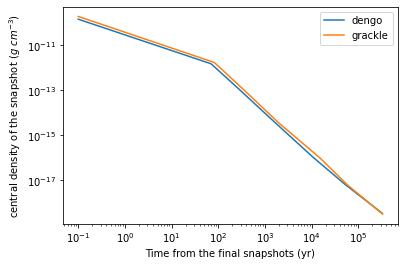

In [4]:
import numpy as np

plt.loglog(
    np.array([(ages_d[-1] - a).to("yr") for a in ages_d]) + 1e-1,
    max_density_d,
    label="dengo",
)
plt.loglog(
    np.array([(ages_g[-1] - a).to("yr") for a in ages_g]) + 1e-1,
    max_density_g,
    label="grackle",
)
plt.xlabel("Time from the final snapshots (yr)")
plt.ylabel("central density of the snapshot ($g ~ cm^{-3}$)")
plt.legend()

## Profile Fields

The profile fields are respectively density, temperature, molecular hydrogen fraction, radial velocity, electron fraction, and cooling time scale.
This is calculated with the help of `yt.create_profile`. A data selector is created and centered around the maximum density cell, with a radius of $10 \mathrm{pc}$. The radial profiles of these specified fields are iteratively calculated for different snapshots of the two simulations.

In [5]:
profile_fields = [
    ("gas", "density"),
    ("gas", "temperature"),
    ("gas", "H2I_fraction"),
    ("gas", "radial_velocity"),
    ("gas", "Electron_fraction"),
    ("gas", "cooling_time"),
]


def get_profiles(dataset, radius, profile_fields):
    # compute the bulk velo
    min_dx = (dataset.length_unit / 2**dataset.max_level).to("au") / 128
    factor = 1000
    _sp = dataset.sphere("m", factor * min_dx)
    bulk_vel = _sp.quantities.bulk_velocity()

    sp = dataset.sphere("m", radius)
    sp.set_field_parameter("bulk_velocity", bulk_vel)

    rp = yt.create_profile(
        sp,
        "radius",
        profile_fields,
        weight_field=("gas", "cell_mass"),
    )
    return rp

In [6]:
dengo_profs = []
for dengo_fn in dengo_snaps:
    dengo_ds = load_dengo_dataset(dengo_fn)
    dengo_profs.append(get_profiles(dengo_ds, (10, "pc"), profile_fields))

grackle_profs = []
for grackle_fn in grackle_snaps:
    grackle_ds = load_grackle_dataset(grackle_fn)
    grackle_profs.append(get_profiles(grackle_ds, (10, "pc"), profile_fields))

yt : [INFO     ] 2022-09-10 23:38:03,739 Parameters: current_time              = 11.286066437975
yt : [INFO     ] 2022-09-10 23:38:03,741 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2022-09-10 23:38:03,742 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-10 23:38:03,744 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-10 23:38:03,745 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-09-10 23:38:03,746 Parameters: current_redshift          = 16.535235523486
yt : [INFO     ] 2022-09-10 23:38:03,747 Parameters: omega_lambda              = 0.724
yt : [INFO     ] 2022-09-10 23:38:03,747 Parameters: omega_matter              = 0.276
yt : [INFO     ] 2022-09-10 23:38:03,748 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-09-10 23:38:03,749 Parameters: hubble_constant           = 0.703
Parsing Hierarchy : 100%|██████████████████████████████████████████████████| 18420/18420 [00:02<00:0

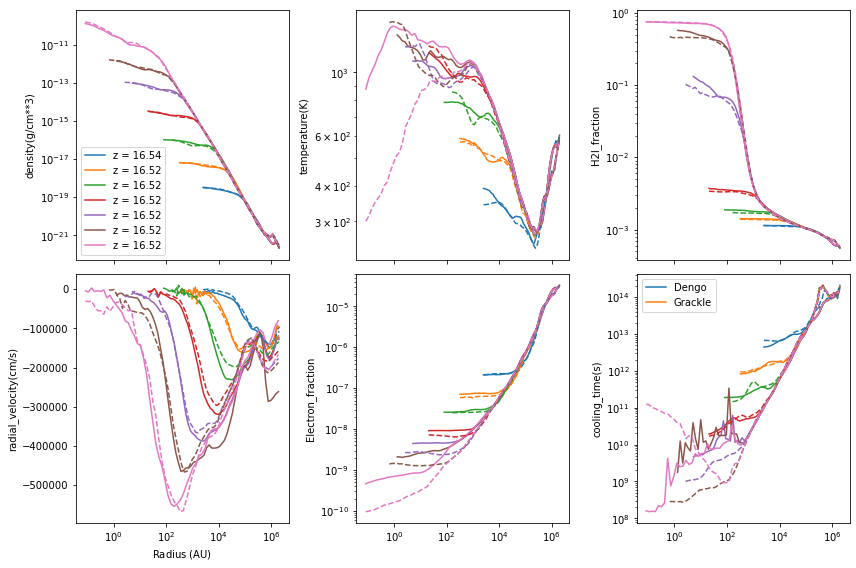

In [7]:
def plot_profile_ax(ax, profile_data, profile_fields, color="C0", ls=None):
    flags = profile_data[pf].value != 0
    if (profile_data[pf].value > 0).all():
        ax.loglog(
            profile_data.x.to("AU").value[flags],
            profile_data[pf].value[flags],
            color=color,
            ls=ls,
        )
    else:
        ax.semilogx(
            profile_data.x.to("AU").value[flags],
            profile_data[pf].value[flags],
            color=color,
            ls=ls,
        )


f, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True)

colors = [f"C{i}" for i in range(len(dengo_profs))]

for rp, color in zip(dengo_profs, colors):
    for ax, pf in zip(axes.flat, profile_fields):
        plot_profile_ax(ax, rp, pf, color=color)

        lb = pf[1]
        if not rp[pf].units.is_dimensionless:
            lb += f"({rp[pf].units})"
        ax.set_ylabel(lb)

for rp, color in zip(grackle_profs, colors):
    for ax, pf in zip(axes.flat, profile_fields):
        plot_profile_ax(ax, rp, pf, color=color, ls="--")

        lb = pf[1]
        if not rp[pf].units.is_dimensionless:
            lb += f"({rp[pf].units})"
        ax.set_ylabel(lb)

axes.flat[0].legend(
    [f"z = {rp.data_source.ds.current_redshift:.2f}" for rp in dengo_profs]
)

axes.flat[-1].legend(["Dengo", "Grackle"])
axes.flat[3].set_xlabel("Radius ($\mathrm{AU}$)")

plt.tight_layout()

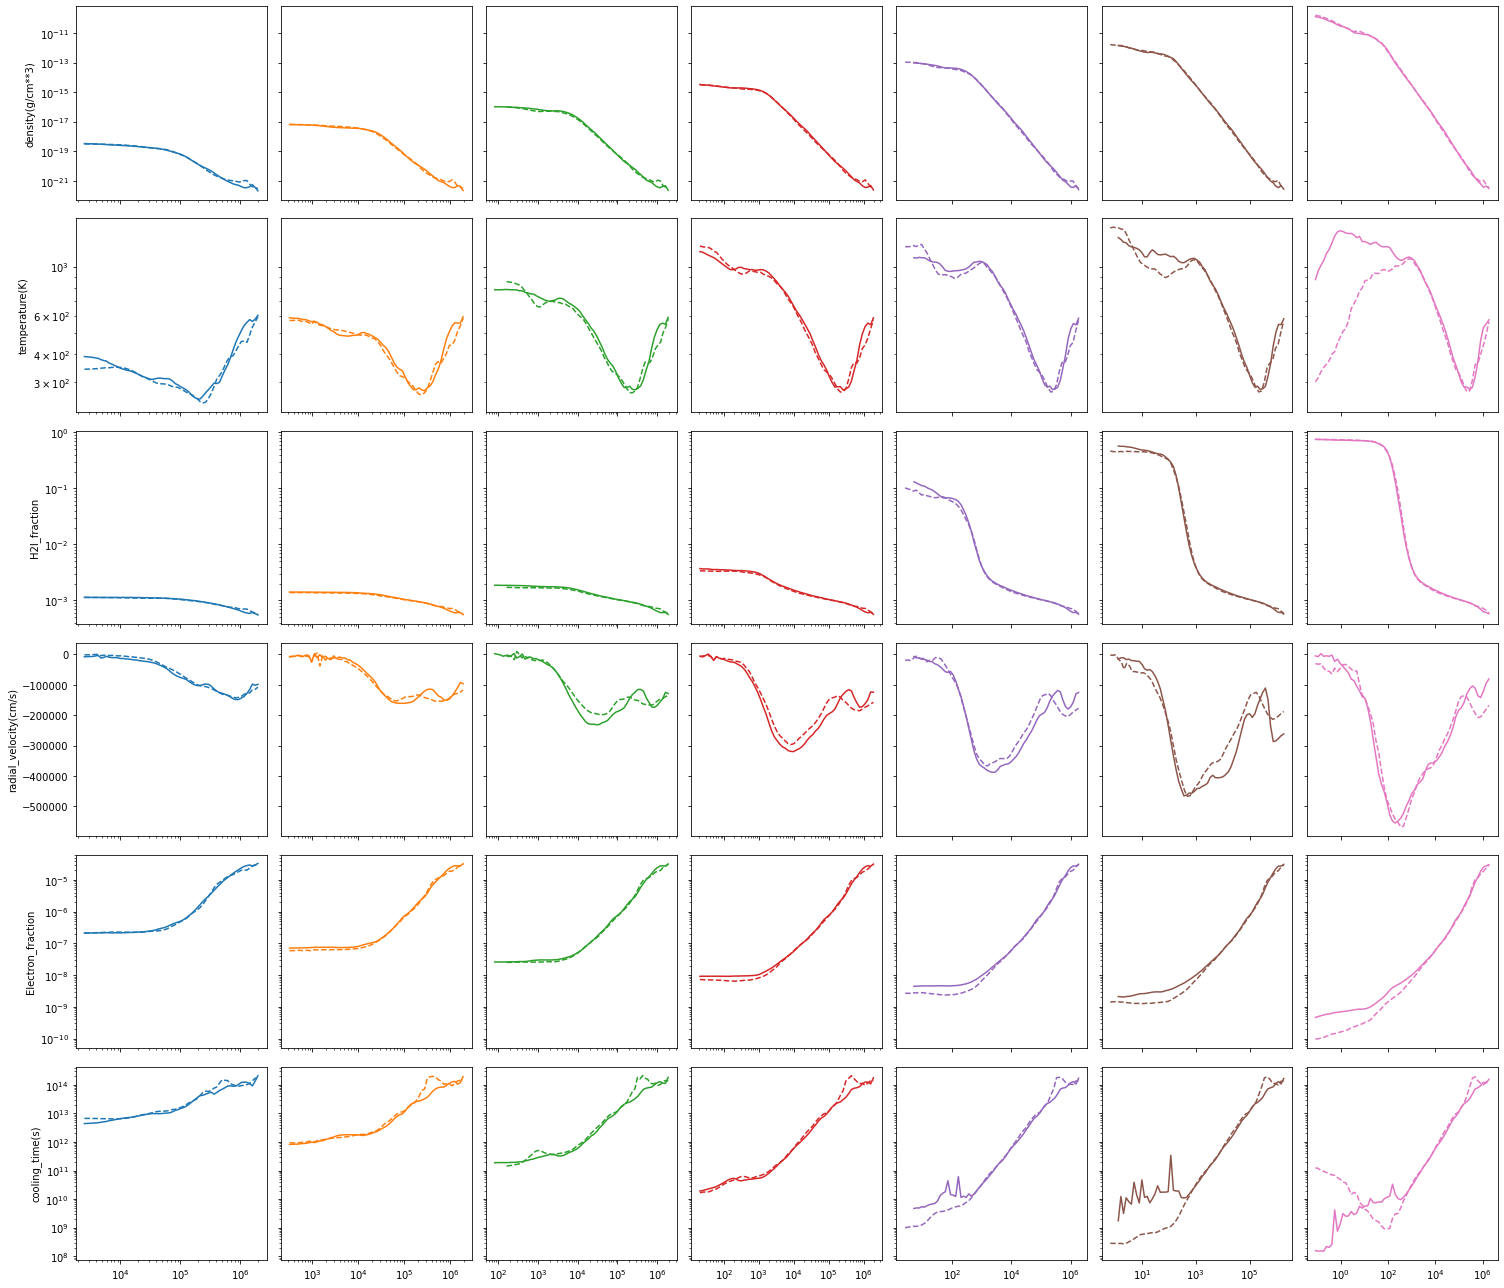

In [8]:
nprof_fields = len(profile_fields)
f, axes = plt.subplots(
    nprof_fields, 7, figsize=(21, 3 * nprof_fields), sharex="col", sharey="row"
)
for i, pf in enumerate(profile_fields):

    j = 0
    for rp_d, rp_g, color, ax in zip(dengo_profs, grackle_profs, colors, axes[i].flat):

        plot_profile_ax(ax, rp_d, pf, color=color)

        plot_profile_ax(ax, rp_g, pf, color=color, ls="--")

        lb = pf[1]
        if not rp_g[pf].units.is_dimensionless:
            lb += f"({rp_g[pf].units})"
        if j == 0:
            ax.set_ylabel(lb)

        if lb == "temperature":
            ax.set_yscale("linear")
        j += 1

plt.tight_layout()

## Enclosed Mass/ Bonnor-Ebert Mass
>In astrophysics, the Bonnor–Ebert mass is the largest mass that an **isothermal** gas sphere embedded in a pressurized medium can have while still remaining in hydrostatic equilibrium.Clouds of gas with masses greater than the Bonnor–Ebert mass must inevitably undergo gravitational collapse to form much smaller and denser objects.
[taken from the wiki page](https://en.wikipedia.org/wiki/Bonnor%E2%80%93Ebert_mass)
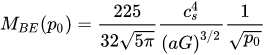

In this section we compare the enclosed mass, and the bonnor-ebert mass, and see it it reaches hydrostatic equilirbium yet in the innermost part. While it assumes the cloud to be isothermal which is not realistic when the temperature profile is non-uniform within the cloud, it is however a good proxy to the first order.

We took the last snapshots of the two simulation with the central density reaches $\sim 3\times10^{-10} ~ \mathrm{g ~ cm^{-3}}$. We compare the enclosed mass and the bonnor ebert mass as a function of radius.

In [9]:
ds_grackle = yt.load(dengo_snaps[-1])
ds_dengo = yt.load(grackle_snaps[-1])

yt : [INFO     ] 2022-09-11 00:12:48,481 Parameters: current_time              = 11.301308754354
yt : [INFO     ] 2022-09-11 00:12:48,483 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2022-09-11 00:12:48,485 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-11 00:12:48,486 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-11 00:12:48,487 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-09-11 00:12:48,488 Parameters: current_redshift          = 16.51946269887
yt : [INFO     ] 2022-09-11 00:12:48,489 Parameters: omega_lambda              = 0.724
yt : [INFO     ] 2022-09-11 00:12:48,490 Parameters: omega_matter              = 0.276
yt : [INFO     ] 2022-09-11 00:12:48,491 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-09-11 00:12:48,491 Parameters: hubble_constant           = 0.703
yt : [INFO     ] 2022-09-11 00:12:48,598 Parameters: current_time              = 11.316448063549
yt :

In [10]:
def evaluate_enclosed_mass(dataset):
    my_sphere = dataset.sphere("m", (1, "pc"))
    # get average pressure, average
    enclosed_mass = yt.create_profile(
        my_sphere, "radius", [("gas", "mass")], weight_field=None, accumulation=True
    )

    p_cs = yt.create_profile(
        my_sphere,
        "radius",
        [("gas", "sound_speed"), ("gas", "pressure")],
        weight_field="cell_mass",
        accumulation=False,
    )

    const = (
        225 / 32 / (5 * 3.14159) ** 0.5 / (1 * yt.units.gravitational_constant) ** 1.5
    )

    cs4 = p_cs[("gas", "sound_speed")] ** 4
    p0sqrt = p_cs[("gas", "pressure")] ** -0.5

    Mbe = const * cs4 * p0sqrt

    # now onto the hydro-analysis

    dpdr = np.diff(p_cs["pressure"]) / np.diff(p_cs.x)

    density_prof = yt.create_profile(
        my_sphere,
        "radius",
        [
            ("gas", "density"),
        ],
        weight_field="cell_mass",
        accumulation=False,
        override_bins={"radius": p_cs.x},
    )

    mass_prof = yt.create_profile(
        my_sphere,
        "radius",
        [("gas", "mass")],
        weight_field=None,
        accumulation=True,
        override_bins={"radius": p_cs.x},
    )
    gravity = (
        yt.units.gravitational_constant
        * mass_prof["mass"]
        / density_prof.x**2
        * density_prof["density"]
    )

    return Mbe, enclosed_mass, gravity, dpdr, mass_prof.x

In [11]:
dengo_MBe, dengo_encl_mass, dengo_gravity, dengo_dpdr, dengo_r = evaluate_enclosed_mass(
    ds_dengo
)

Parsing Hierarchy : 100%|██████████████████████████████████████████████████| 21992/21992 [00:05<00:00, 3939.56it/s]
yt : [INFO     ] 2022-09-11 00:12:54,921 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-09-11 00:13:11,550 max value is 1.89069e-10 at 0.4980918404980912 0.5005802176092402 0.4986024849858950


In [12]:
(
    grackle_MBe,
    grackle_encl_mass,
    grackle_gravity,
    grackle_dpdr,
    grackle_r,
) = evaluate_enclosed_mass(ds_grackle)

Parsing Hierarchy : 100%|██████████████████████████████████████████████████| 22287/22287 [00:02<00:00, 9063.81it/s]
yt : [INFO     ] 2022-09-11 00:14:04,438 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-09-11 00:15:46,879 max value is 1.42583e-10 at 0.4980584005315905 0.5005448366355267 0.4986057875721599


Text(0.5, 1.0, 'Grackle')

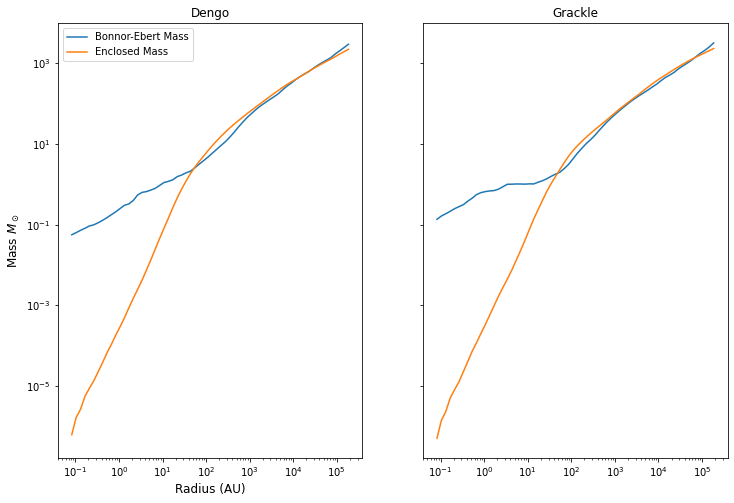

In [13]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 8))
ax[0].loglog(
    dengo_encl_mass.x.to("au"), dengo_MBe.to("Msun"), label="Bonnor-Ebert Mass"
)
ax[0].loglog(
    dengo_encl_mass.x.to("au"),
    dengo_encl_mass["mass"].to("Msun"),
    label="Enclosed Mass",
)

ax[0].set_xlabel("Radius (AU)", fontsize=12)
ax[0].set_ylabel("Mass $M_\odot$", fontsize=12)
ax[0].set_title("Dengo")
ax[0].legend()

ax[1].loglog(grackle_encl_mass.x.to("au"), grackle_MBe.to("Msun"))
ax[1].loglog(grackle_encl_mass.x.to("au"), grackle_encl_mass["mass"].to("Msun"))
ax[1].set_title("Grackle")

## Pressure Gradient and Self-Gravity
- The competition between the thermal support and the self-gravity determine whether the cloud is undergoing self-gravitating collapse.
- $\frac{dP}{dr}$ refers to the pressure gradient. We caculate it by first computing the radially average pressure, and evaluate the pressure gradient by taking the numerical derivatives of it.
- $\frac{G M(r) \rho(r) }{r^2}$ is the self gravity term, where 
- when the self gravity dominates over the thermal support, $\frac{dP}{dr} / \frac{G M(r) \rho }{r^2} $ the ratio goes below 1, and vice-versa.
This show give similar results as our above analysis with enclosed mass/ bonnor-ebert mass.

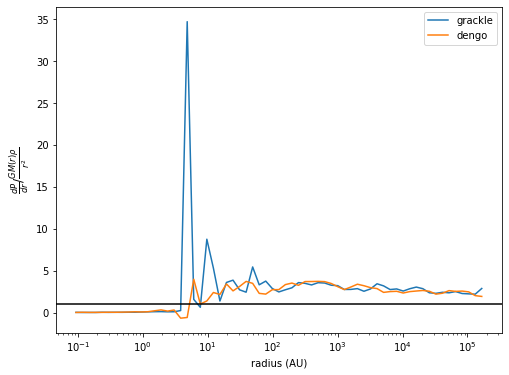

In [14]:
plt.figure(figsize=(8, 6))
plt.semilogx(
    grackle_r.to("au"),
    (grackle_gravity / -grackle_dpdr).to("dimensionless"),
    label="grackle",
)
plt.semilogx(
    grackle_r.to("au"), (dengo_gravity / -dengo_dpdr).to("dimensionless"), label="dengo"
)
plt.ylabel(r"$\frac{dP}{dr} / \frac{G M(r) \rho }{r^2} $", fontsize=12)
plt.legend()
plt.xlabel("radius (AU)")
plt.axhline(1, color="k")

## Heating/ Cooling Profiles

In [15]:
profile_fields = [
    ("gas", "h2formation"),
    ("gas", "gloverabel08"),
    ("gas", "cie_cooling"),
    ("gas", "thermal_timescale"),
    ("gas", "net_heating_over_tdyn"),
    ("gas", "cooling_time"),
]

dengo_profs = []
for dengo_fn in dengo_snaps:
    dengo_ds = load_dengo_dataset(dengo_fn)
    dengo_profs.append(get_profiles(dengo_ds, (10, "pc"), profile_fields))

grackle_profs = []
for grackle_fn in grackle_snaps:
    grackle_ds = load_grackle_dataset(grackle_fn)
    grackle_profs.append(get_profiles(grackle_ds, (10, "pc"), profile_fields))

yt : [INFO     ] 2022-09-11 00:16:52,059 Parameters: current_time              = 11.286066437975
yt : [INFO     ] 2022-09-11 00:16:52,060 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2022-09-11 00:16:52,062 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-11 00:16:52,064 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-11 00:16:52,065 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-09-11 00:16:52,065 Parameters: current_redshift          = 16.535235523486
yt : [INFO     ] 2022-09-11 00:16:52,066 Parameters: omega_lambda              = 0.724
yt : [INFO     ] 2022-09-11 00:16:52,067 Parameters: omega_matter              = 0.276
yt : [INFO     ] 2022-09-11 00:16:52,068 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-09-11 00:16:52,069 Parameters: hubble_constant           = 0.703
Parsing Hierarchy : 100%|██████████████████████████████████████████████████| 18420/18420 [00:01<00:0

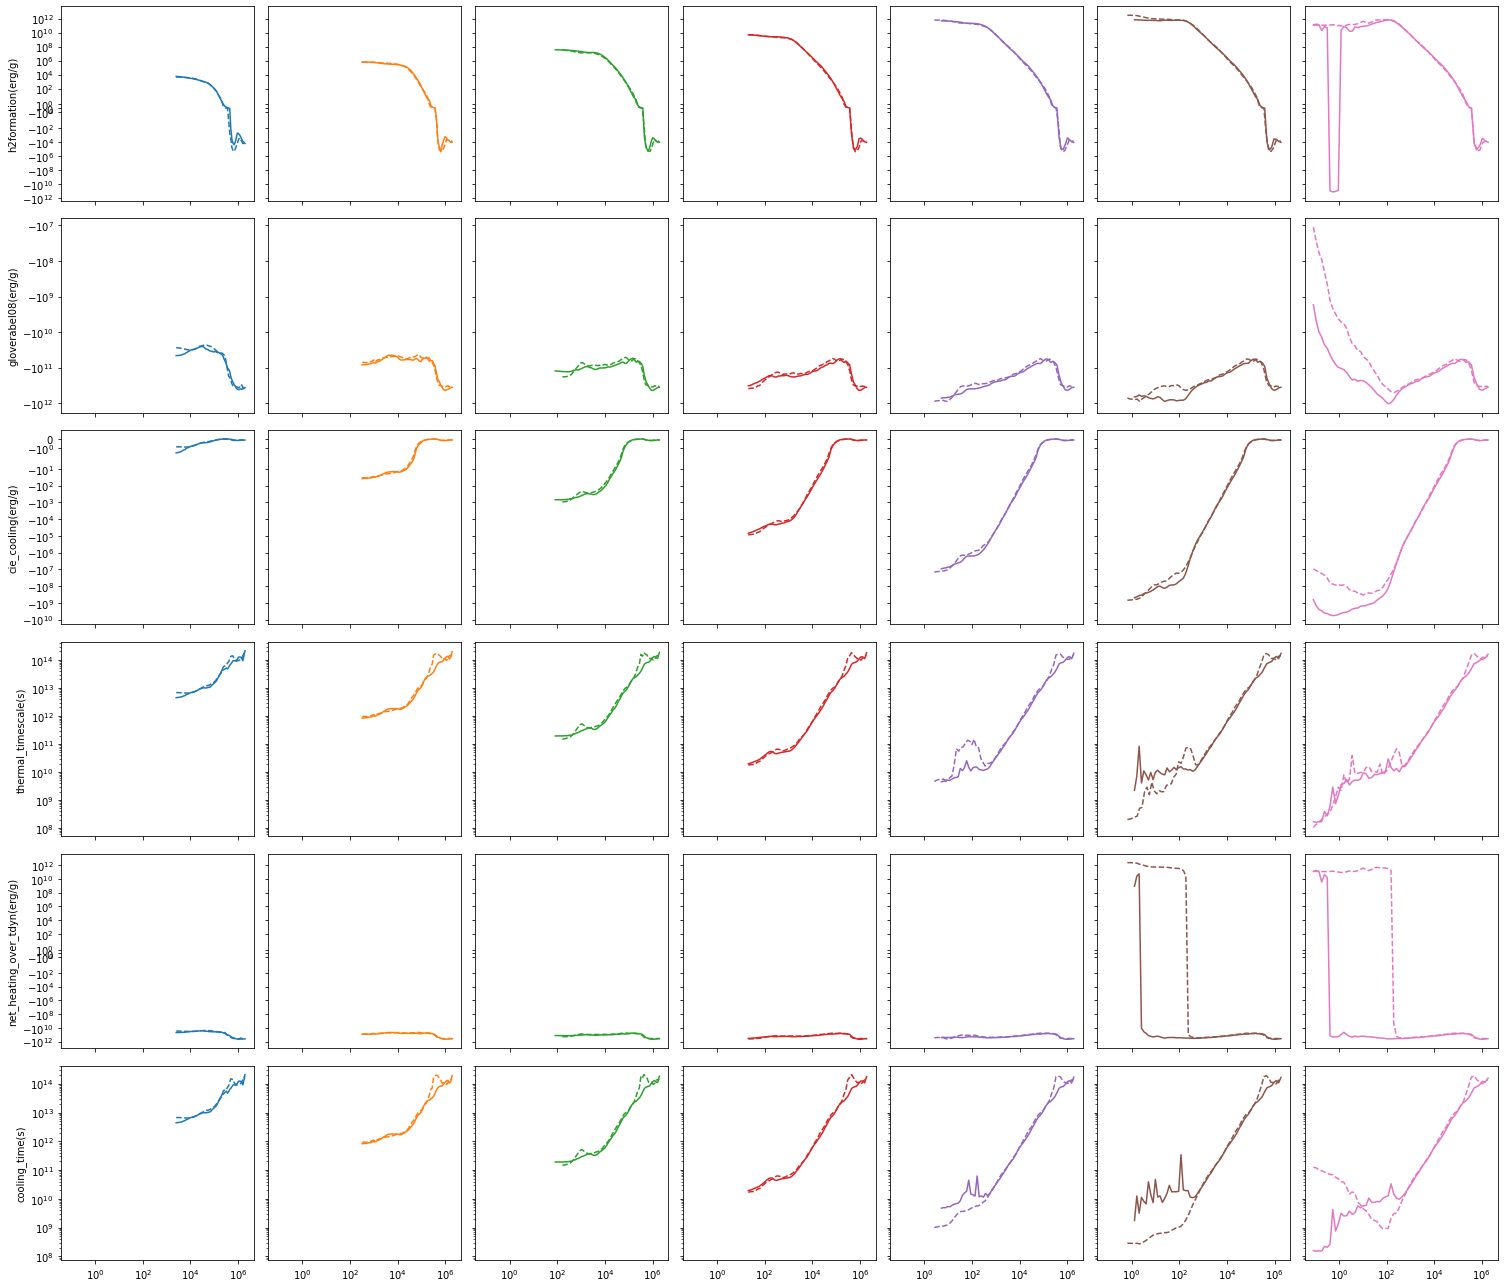

In [20]:
# def plot_profile_fields(profile_fields, sharex='all', sharey='row', yscale='symlog'):
nprof_fields = len(profile_fields)
nprofs = len(dengo_profs)
f, axes = plt.subplots(
    nprof_fields,
    nprofs,
    figsize=(3 * nprofs, 3 * nprof_fields),
    sharex="all",
    sharey="row",
)

for i, pf in enumerate(profile_fields):

    j = 0
    for rp_d, rp_g, color, ax in zip(dengo_profs, grackle_profs, colors, axes[i].flat):
        # solid lines are from DENGO
        plot_profile_ax(ax, rp_d, pf, color=color)
        # dash lines are from grackle
        plot_profile_ax(ax, rp_g, pf, color=color, ls="--")

        lb = pf[1]
        if not rp_g[pf].units.is_dimensionless:
            lb += f"({rp_g[pf].units})"
        if j == 0:
            ax.set_ylabel(lb)

            ax.set_yscale("symlog")
        j += 1

plt.tight_layout()
#     return f